# TDLMC rung3 sample preparation
This notebook compiles the TDLMC rung3 from Millon and Galan. It uses the 1d Ddt posteriors and re-processes the the kinematics to allow for an explicit treatment of the anisotropy and MST assumptions in the hierarchical approach.

Requirements:
- hierArc: https://github.com/sibirrer/hierArc (master branch)
- lenstronomy: https://github.com/sibirrer/lenstronomy (master branch)
- corner

last edited: 19.6.2020

author: Simon Birrer (sibirrer@gmail.com)


review: Aymeric Galan (aymeric.galan@gmail.com)

In [1]:
from hierarc.LensPosterior.ddt_kin_gauss_constraints import DdtGaussKinConstraints
from hierarc.Sampling.mcmc_sampling import MCMCSampler
import copy
import numpy as np
import os
import csv
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import corner
import emcee
%matplotlib inline

from pylab import rc
rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)

In [2]:
H0_true = 65.413  # ground truth of TDLMC rung3
Omega_m_true = 0.27  # fixed given Omega_m for the TDLMC
kappa_ext_mean = 0  # mean external convergence provided by the TDLMC
kappa_ext_sigma = 0.025  # Gaussian 1-sigma scatter provided by the TDLMC

In [3]:
# numerical settings (not needed if power-law profiles with Hernquist light distribution is computed)
kwargs_numerics_galkin = {'interpol_grid_num': 1000,  # numerical interpolation, should converge -> infinity
                          'log_integration': True,  # log or linear interpolation of surface brightness and mass models
                           'max_integrate': 100, 'min_integrate': 0.001}  # lower/upper bound of numerical integrals

anisotropy_model = 'OM'  # 'OM' for Osikpov-Merritt parametrization, 'GOM' for Generalized Osikpov-Merritt parametrization
sigma_v_systematics = False  # boolean, if True, adds a free parameter that adds an error in the kinematic likelihood (due to unaccounted measurement or modeling errors)
lambda_slope = True  # allow for linear scaling of lambda_int with r_eff/theta_E

if lambda_slope is True:
    slope_prefix = '_alpha_lambda'
else:
    slope_prefix = ''


dir_path = os.getcwd()

table_name = 'tdlmc_rung3_posterior_table.csv'
table_file_path = os.path.join(dir_path, table_name)

pre_process_kinematics = False  # boolean, if True, performs first the kinematic modeling to derive the likelihood covariance matrix, if False, uses the existing one

kappa_ext_pre_process = False  # boolean, if True, folds in the external convergence distribution directly on the ddt posterior. If false, samples from the distribution in the hierarchical sampling. Both methods lead to the same result with differnt numerics.


In [4]:
def process_sample(file_name, num_sample_model=50):
    #num_re_sample: number of posterior points to be sampled from one kinematic sample
    posterior_list = []
    bandwidth = 2
    kde_type = 'scipy_gaussian'  # 'gaussian', 'epanechnikov', 'scipy_gaussian'
    
    with open(file_name, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            if float(row['flag']) > -1:
                name = row['name']
                print(name)
                z_lens = float(row['z_lens'])
                # here we add the external convergence uncertainty (mean=0) directly on the time-delay distance uncertainty
                # without applying the correction on the kinematics, as this has been done in the generation of the model
                if kappa_ext_pre_process is True:
                    ddt_sigma = np.sqrt(float(row['Ddt_sigma'])**2 + kappa_ext_sigma**2*float(row['Ddt_mean']))
                else:
                    ddt_sigma = float(row['Ddt_sigma'])
                kwargs = {'z_lens': float(row['z_lens']), 'z_source': float(row['z_source']),
                          'ddt_mean': float(row['Ddt_mean']), 'ddt_sigma': ddt_sigma,
                               'sigma_v': [float(row['sigma_v'])], 'sigma_v_error_independent': [float(row['sigma_v_error'])],
                               'r_eff': float(row['r_eff']), 'r_eff_error': float(row['r_eff_error']),
                               'theta_E': float(row['theta_E']), 'theta_E_error': float(row['theta_E_error']),
                               'gamma': float(row['gamma']), 'gamma_error': float(row['gamma_error']),
                         }
                kwargs_lens_light = None  # will be automatically generated as we give effective radius r_eff
                # we assume Hernquist light profile for the deflector, which has analytical 3D de-projection
                # so we turn off the multi-gaussian expansion
                MGE_light, kwargs_mge_light =  False, None
                
                kwargs_aperture = {'aperture_type': 'slit', 'length': float(row['slit_length']), 'width': float(row['slit_width']), 'center_ra': 0.0, 'center_dec': 0, 'angle': 0}
                kwargs_seeing = {'psf_type': 'GAUSSIAN', 'fwhm': float(row['psf_fwhm'])}
                ddtKinConstraints = DdtGaussKinConstraints(kwargs_aperture=kwargs_aperture, kwargs_seeing=kwargs_seeing, 
                                                      kwargs_numerics_galkin=kwargs_numerics_galkin, 
                                                      anisotropy_model=anisotropy_model, kwargs_lens_light=kwargs_lens_light, 
                                                      lens_light_model_list=['HERNQUIST'], MGE_light=MGE_light, sigma_v_error_covariant=0,
                                                      kwargs_mge_light=kwargs_mge_light, num_kin_sampling=2000, num_psf_sampling=500, **kwargs)
                
                kwargs_posterior = ddtKinConstraints.hierarchy_configuration(num_sample_model=num_sample_model)
                kwargs_posterior['name'] = name
                kwargs_posterior['flag'] = float(row['flag'])
                posterior_list.append(kwargs_posterior)
                
    return posterior_list

def properties(name, file_name):
    with open(file_name, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            if name == str(row['name']):
                theta_E = float(row['theta_E'])
                r_eff = float(row['r_eff'])
                return theta_E, r_eff

In [5]:
if anisotropy_model == 'OM':
    if kappa_ext_pre_process is True:
        input_file = 'tdlmc_rung3_om_processed_with_kappa.pkl'
    else:
        input_file = 'tdlmc_rung3_om_processed.pkl'
elif anisotropy_model == 'GOM':
    if kappa_ext_pre_process is True:
        input_file = 'tdlmc_rung3_gom_processed_with_kappa.pkl'
    else:
        input_file = 'tdlmc_rung3_gom_processed.pkl'
else:
    raise ValueError('anisotropy model %s not available' % anisotropy_model)

if pre_process_kinematics is True:
    posterior_list = process_sample(table_file_path, num_sample_model=50)
    file = open(input_file, 'wb')
    pickle.dump(posterior_list, file)
    file.close()


## Cosmographic inference

In [6]:
num_distribution_draws = 100  # number of draws from the distribution to marginalize the likelihood (Monte Carlo integral)
# more samples lead to higher precision on the individual likelihood for the cost of speed.

run_chains = False  # boolean, if True, runs the chains, else uses the stored chains to do the plotting 
continue_from_backend = True  # boolean, if True, continues sampling the emcee chain from a backend (if exists), otherwise deletes previous chains and starts from scratch 

n_walkers = 100  # number of walkers in the emcee sampling
n_run = 500  # number of iterations used in the posteriors
n_burn = 100  # number of iterations to burn-in the emcee

# anisotropy bounds in the sampling
beta_inf_min, beta_inf_max = 0, 1
a_ani_min, a_ani_max, aniso_param_mean = 0.1, 5, 1

# here we load the pre-processed individual lens likelihoods
file = open(input_file, 'rb')
posterior_list = pickle.load(file)
file.close()




kwargs_lens_list = []
for posterior in posterior_list:
    lens = copy.deepcopy(posterior)
    #lens['ddt_sigma'] = lens['ddt_weights']
    #del lens['ddt_weights']
    if kappa_ext_pre_process is False:
        lens['kappa_ext_bias'] = True  # whether or not to sample the external convergence in the likelihood computation
    lens['num_distribution_draws'] = num_distribution_draws
    lens['sigma_sys_error_include'] = sigma_v_systematics
    name = lens['name']
    theta_E, r_eff = properties(name, table_file_path)
    lens['lambda_scaling_property'] = r_eff/theta_E - 1
    del lens['flag']
    kwargs_lens_list.append(lens)

cosmology = 'FLCDM'  # available models: 'FLCDM', "FwCDM", "w0waCDM", "oLCDM"
# parameters are: 'h0', 'om', 'ok', 'w', 'w0', 'wa'

# we specify the allowed range in the parameters to be sampled and which to held fix.

kwargs_lower_cosmo = {'h0': 1, 'om': 0.05}
kwargs_lower_lens = {'lambda_mst': 0.5, 'lambda_mst_sigma': 0, 'alpha_lambda': -1}
kwargs_lower_kin = {'a_ani': a_ani_min, 'a_ani_sigma': 0, 'beta_inf': beta_inf_min, 'beta_inf_sigma': 0, 'sigma_v_sys_error': 0}

kwargs_upper_cosmo = {'h0': 150, 'om': 0.5}
kwargs_upper_lens = {'lambda_mst': 1.5, 'lambda_mst_sigma': 1., 'alpha_lambda': 1}
kwargs_upper_kin = {'a_ani': a_ani_max, 'a_ani_sigma': 1. ,'beta_inf': beta_inf_max, 'beta_inf_sigma': 1, 'sigma_v_sys_error': 0.5}

kwargs_fixed_cosmo = {}
if kappa_ext_pre_process is True:
    kwargs_fixed_lens = {'kappa_ext': 0, 'kappa_ext_sigma': 0}
else:
    kwargs_fixed_lens = {'kappa_ext': kappa_ext_mean, 'kappa_ext_sigma': kappa_ext_sigma}
kwargs_fixed_kin = {}

# starting sample of the parameters
kwargs_mean_start = {'kwargs_cosmo': {'h0': 70, 'om': 0.3},
                     'kwargs_lens': {'lambda_mst': 1., 'lambda_mst_sigma': .05, 'alpha_lambda': 0},
                     'kwargs_kin': {'a_ani': 1, 'a_ani_sigma': 0.1, 'beta_inf': 0.8, 'beta_inf_sigma': 0.1, 'sigma_v_sys_error': 0}}

kwargs_sigma_start = {'kwargs_cosmo': {'h0': 10, 'om': 0.1},
                     'kwargs_lens': {'lambda_mst': .1, 'lambda_mst_sigma': .05, 'alpha_lambda': 0.1},
                     'kwargs_kin': {'a_ani': 0.3, 'a_ani_sigma': 0.1, 'beta_inf': 0.5, 'beta_inf_sigma': 0.1, 'sigma_v_sys_error': 0.05}}




class CustomPrior(object):
    """
    customized prior instance. Here we use a 1/a_ani prior to explore.
    """
    def __init__(self):
        pass
        
    def __call__(self, kwargs_cosmo, kwargs_lens, kwargs_kin):
        return self.log_likelihood(kwargs_cosmo, kwargs_lens, kwargs_kin)
    
    def log_likelihood(self, kwargs_cosmo, kwargs_lens, kwargs_kin):

        logL = 0
        a_ani = kwargs_kin.get('a_ani', 1)
        logL += np.log(1/a_ani)
        return logL

def anisotropy_trend(posterior_list):
    """
    plots the trend of infered Ds/Dds as a function of anisotropy radius/r_eff
    
    :param name: string, name of lens in the catalogue
    """
    for posterior in posterior_list:
        name = posterior['name']
        if anisotropy_model == 'GOM':
            a_ani_array = posterior['ani_param_array'][0]
            scaling_array = posterior['ani_scaling_array_list'][0][:, 2]
        else:
            a_ani_array = posterior['ani_param_array']
            scaling_array = posterior['ani_scaling_array_list'][0]
        plt.plot(a_ani_array, scaling_array, label=name)
    plt.xlabel(r'$a_{\rm ani}$', fontsize=20)
    plt.ylabel(r'$(\sigma^{\rm P})^2 / (\sigma^{\rm P})^2(a_{\rm ani} = 1)$', fontsize=20)
    plt.legend()
    plt.show()


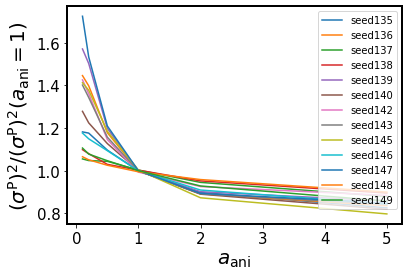

-77.70938760862323 log likelihood
5.977645200663326 reduced chi2


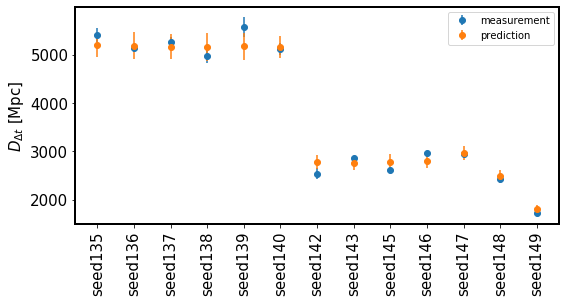

-78.73236971029861 log likelihood


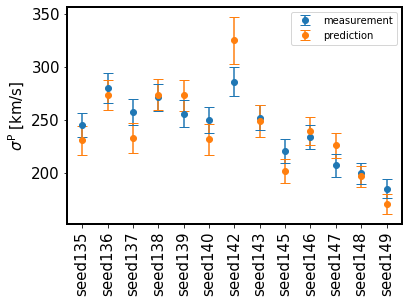

In [7]:
from hierarc.Diagnostics.goodness_of_fit import GoodnessOfFit

fit = GoodnessOfFit(kwargs_lens_list)

anisotropy_trend(posterior_list=posterior_list)

from astropy.cosmology import FlatLambdaCDM
cosmo_true = FlatLambdaCDM(H0=H0_true, Om0=Omega_m_true)

kwargs_lens_plot = {'lambda_mst': 1.08, 'lambda_mst_sigma': 0.05, 
                    'kappa_ext': kappa_ext_mean, 'kappa_ext_sigma': kappa_ext_sigma, 'alpha_lambda': 0}
kwargs_kin_plot = {'a_ani': 1.5, 'a_ani_sigma': 0.5, 'beta_inf': 1}

fig, axes = fit.plot_ddt_fit(cosmo=cosmo_true, kwargs_lens=kwargs_lens_plot, kwargs_kin=kwargs_kin_plot)
plt.show()

fig, axes = fit.plot_kin_fit(cosmo=cosmo_true, kwargs_lens=kwargs_lens_plot, kwargs_kin=kwargs_kin_plot)
plt.show()


In [8]:
kwargs_bounds = {'kwargs_lower_cosmo': kwargs_lower_cosmo,
                'kwargs_lower_lens': kwargs_lower_lens,
                'kwargs_lower_kin': kwargs_lower_kin,
                'kwargs_upper_cosmo': kwargs_upper_cosmo,
                'kwargs_upper_lens': kwargs_upper_lens,
                'kwargs_upper_kin': kwargs_upper_kin,
                'kwargs_fixed_cosmo': kwargs_fixed_cosmo,
                'kwargs_fixed_lens': kwargs_fixed_lens,
                'kwargs_fixed_kin': kwargs_fixed_kin}

kwargs_sampler = {'lambda_mst_sampling': True,
                 'lambda_mst_distribution': 'GAUSSIAN',
                 'anisotropy_sampling': True,
                 'kappa_ext_sampling': True,
                 'kappa_ext_distribution': 'GAUSSIAN',
                 'sigma_v_systematics': sigma_v_systematics,
                 'anisotropy_model': anisotropy_model,
                 'anisotropy_distribution': 'GAUSSIAN',
                 'alpha_lambda_sampling': lambda_slope,
                 'interpolate_cosmo': True, 'num_redshift_interp': 100}

mcmc_sampler_free = MCMCSampler(kwargs_lens_list, cosmology, kwargs_bounds, 
                                custom_prior=CustomPrior(), **kwargs_sampler)

filename = "tdlmc_free_omega_m_chain"+anisotropy_model+slope_prefix+".h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_cosmo_free, log_prob_cosmo = mcmc_sampler_free.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                           kwargs_mean_start, kwargs_sigma_start, 
                                                                           continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_cosmo_free = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_cosmo = backend.get_log_prob(discard=n_burn, flat=True, thin=1)





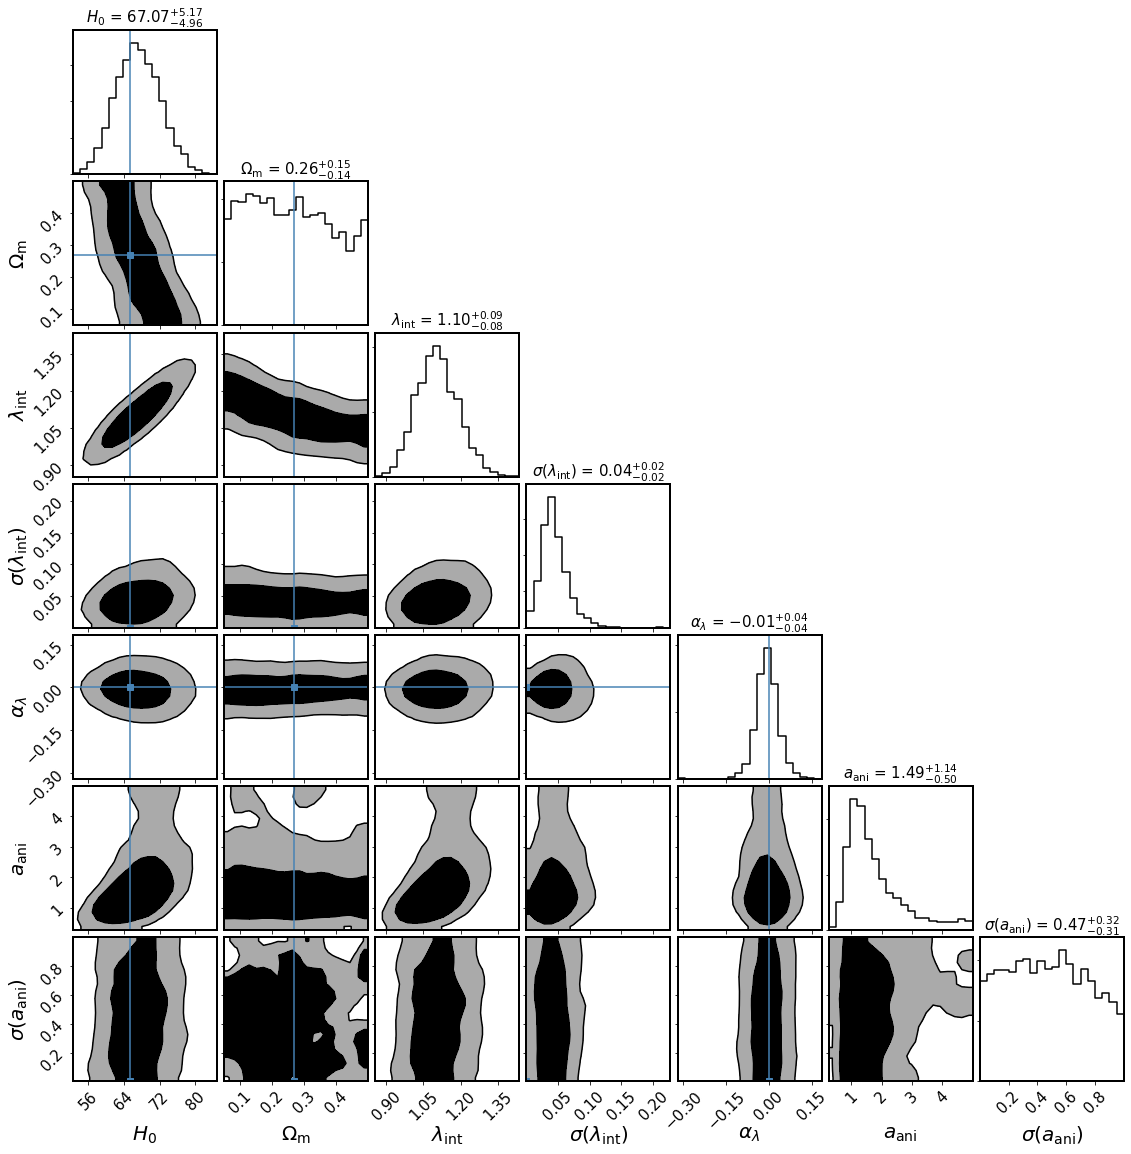

In [9]:
fig = corner.corner(mcmc_samples_cosmo_free,
                    labels=mcmc_sampler_free.param_names(latex_style=True),
                    bins=20,
                    smooth=1, smooth1d=0.,
                    show_titles=True,
                    title_kwargs=dict(fontsize=15),
                    plot_datapoints=False,
                    label_kwargs=dict(fontsize=20),
                    truths=[H0_true, Omega_m_true, 0, 0, 0, 0, 0, 0, 0],
                    levels=[0.68,0.95],
                    #levels=(1-np.exp(-0.5),1-np.exp(-1)),
                    #color=color_map[0],
                    fill_contours=True,
                    #range=plot_limits,
                    #truth_color=truth_color
                   )
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/tdlmc_rung3_free_'+str(anisotropy_model)+'.pdf')



In [10]:
# here we fix omega_m to the given true value and infer the Hubble constant profile and anisotropy parameters
kwargs_bounds = {'kwargs_lower_cosmo': kwargs_lower_cosmo,
                'kwargs_lower_lens': kwargs_lower_lens,
                'kwargs_lower_kin': kwargs_lower_kin,
                'kwargs_upper_cosmo': kwargs_upper_cosmo,
                'kwargs_upper_lens': kwargs_upper_lens,
                'kwargs_upper_kin': kwargs_upper_kin,
                'kwargs_fixed_cosmo': dict(**kwargs_fixed_cosmo, **{'om': 0.27}),
                'kwargs_fixed_lens': kwargs_fixed_lens,
                'kwargs_fixed_kin': kwargs_fixed_kin}

mcmc_sampler_fixed_omega_m = MCMCSampler(kwargs_lens_list, cosmology, kwargs_bounds, 
                                custom_prior=CustomPrior(), **kwargs_sampler)

filename = "tdlmc_chain"+anisotropy_model+slope_prefix+".h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_cosmo_fixed_omega_m, log_prob = mcmc_sampler_fixed_omega_m.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                                       kwargs_mean_start, kwargs_sigma_start, 
                                                                                       continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_cosmo_fixed_omega_m = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob = backend.get_log_prob(discard=n_burn, flat=True, thin=1)


mcmc_sampler_fixed_omega_m_flat_ani = MCMCSampler(kwargs_lens_list, cosmology, kwargs_bounds, 
                                custom_prior=None, **kwargs_sampler)

filename = "tdlmc_flat_a_ani_chain"+anisotropy_model+slope_prefix+".h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_cosmo_fixed_omega_m_flat_ani, log_prob = mcmc_sampler_fixed_omega_m_flat_ani.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                                                         kwargs_mean_start, kwargs_sigma_start, 
                                                                                                         continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_cosmo_fixed_omega_m_flat_ani = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob = backend.get_log_prob(discard=n_burn, flat=True, thin=1)




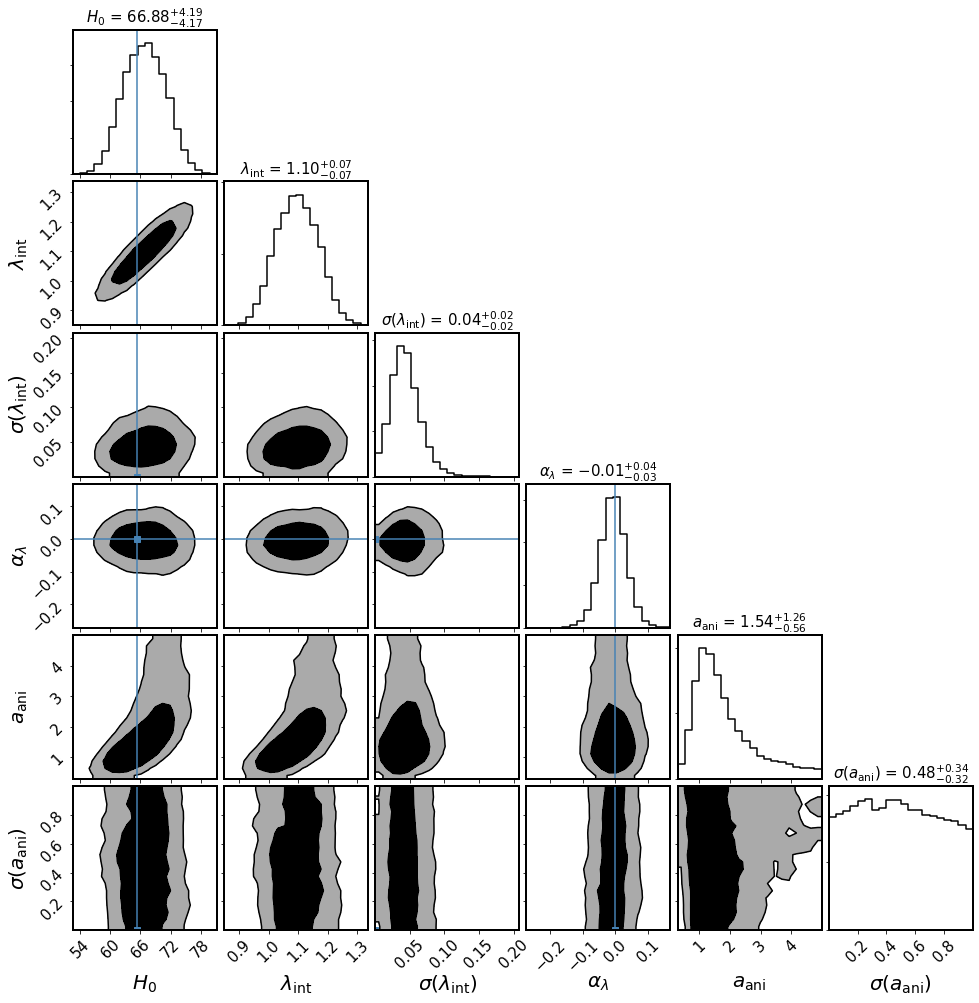

In [11]:
fig = corner.corner(mcmc_samples_cosmo_fixed_omega_m,
                    labels=mcmc_sampler_fixed_omega_m.param_names(latex_style=True),
                    bins=20,
                    smooth=0.7, smooth1d=0.7,
                    show_titles=True,
                    title_kwargs=dict(fontsize=15),
                    plot_datapoints=False,
                    label_kwargs=dict(fontsize=20),
                    truths=[H0_true, Omega_m_true, 0, 0, 0, 0, 0, 0, 0],
                    levels=[0.68,0.95],
                    #color=color_map[0],
                    fill_contours=True,
                    #range=plot_limits,
                    #truth_color=truth_color
                   )

#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/tdlmc_rung3_fixed_omega_m_'+str(anisotropy_model)+'.pdf')




/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


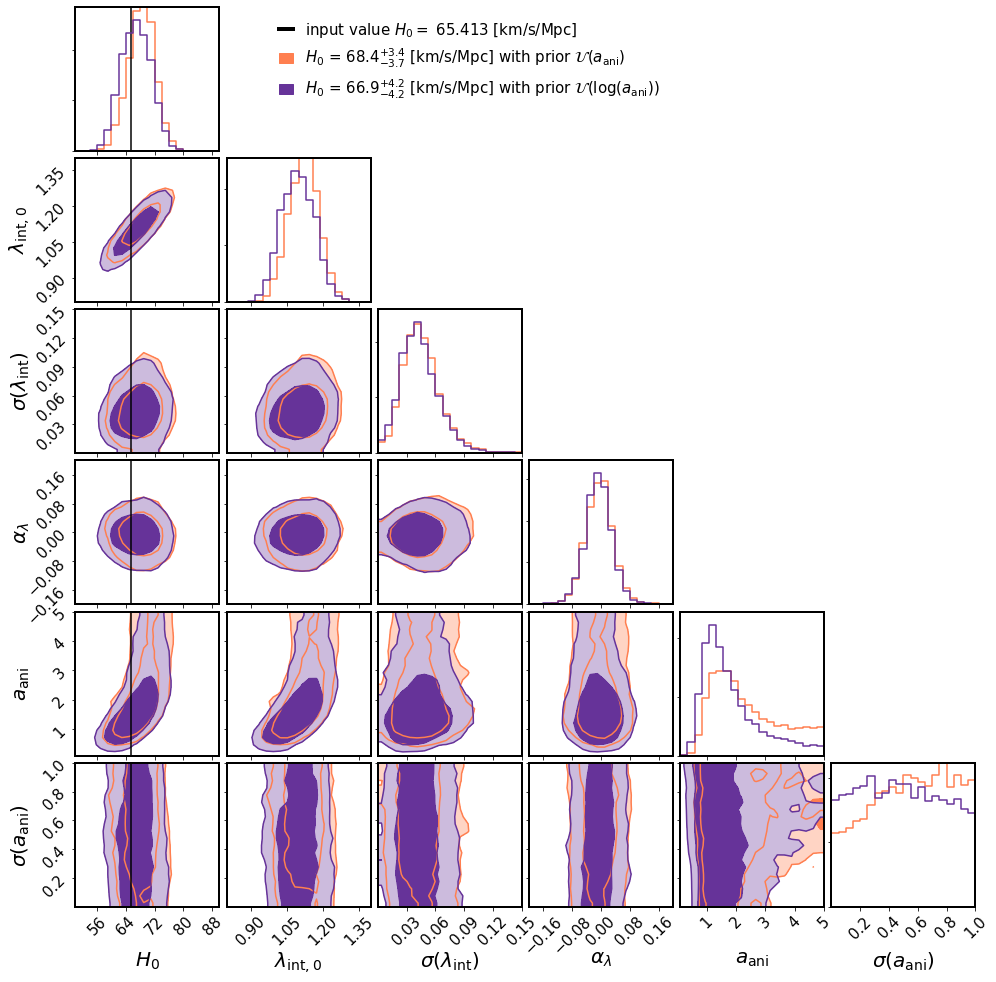

In [12]:
from lenstronomy.Plots import plot_util

if sigma_v_systematics is True:
    extents = [[50, 90], [0.8, 1.4], [0, 0.15], [-0.2, 0.2], [0.1, 5], [0, 1], [0, 0.15]]
else:
    extents = [[50, 90], [0.8, 1.4], [0, 0.15], [-0.2, 0.2], [0.1, 5], [0, 1]]
if anisotropy_model == 'GOM':
    extents += [[0, 1], [0, 1]]
#extents = None

kwargs_corner = {'bins': 20, 'smooth': 0.7, 'smooth1d': 0.1, 'alpha': 0.2,
                'range': extents, 'plot_datapoints': False, 'levels': [0.68,0.95],
                'fill_contours': True, 'truth_color': 'k'}
labels=mcmc_sampler_fixed_omega_m.param_names(latex_style=True)
labels[1] = r'$\lambda_{\rm int, 0}$'

fig = corner.corner(mcmc_samples_cosmo_fixed_omega_m_flat_ani,
                    labels=labels,
                    color='coral',
                    title_kwargs=dict(fontsize=15),
                    label_kwargs=dict(fontsize=20),
                    truths=[H0_true, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                    **kwargs_corner
                    #hist_kwargs={'color': 'r'}
                   )
fig = corner.corner(mcmc_samples_cosmo_fixed_omega_m,
                    #labels=mcmc_sampler_fixed_omega_m_flat_ani.param_names(latex_style=True),
                    color='rebeccapurple', fig=fig, **kwargs_corner)

# rebeccapurple, purple

ax = fig.axes[3]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
result_string_cosmo = plot_util.result_string(mcmc_samples_cosmo_fixed_omega_m[:,0], weights=None, title_fmt=".1f", label=r'$H_0$')
result_string_cosmo_ani_flat = plot_util.result_string(mcmc_samples_cosmo_fixed_omega_m_flat_ani[:,0], weights=None, title_fmt=".1f", label=r'$H_0$')


alpha= 1
patch_3 = mpatches.Patch(color='rebeccapurple', label=result_string_cosmo + r' [km/s/Mpc] with prior $\mathcal{U}(\log(a_{\rm ani}))$', alpha=alpha)
patch_2 = mpatches.Patch(color='coral', label=result_string_cosmo_ani_flat + r' [km/s/Mpc] with prior $\mathcal{U}(a_{\rm ani})$', alpha=alpha)

from matplotlib.lines import Line2D
patch_1 = Line2D([0], [0], color='k', lw=4, label= r'input value $H_0 =$ ' + str(H0_true) + r' [km/s/Mpc]')
ax.legend(handles=[patch_1, patch_2, patch_3], fontsize=15, handlelength=0.9, loc=1, frameon=False)
fig.show()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/tdlmc_rung3_fixed_omega_m_'+str(anisotropy_model)+'.pdf')
plt.show()



In [13]:
# and here we fix the cosmology to the truth

kwargs_bounds = {'kwargs_lower_cosmo': kwargs_lower_cosmo,
                'kwargs_lower_lens': kwargs_lower_lens,
                'kwargs_lower_kin': kwargs_lower_kin,
                'kwargs_upper_cosmo': kwargs_upper_cosmo,
                'kwargs_upper_lens': kwargs_upper_lens,
                'kwargs_upper_kin': kwargs_upper_kin,
                'kwargs_fixed_cosmo': {'h0': H0_true, 'om': Omega_m_true},
                'kwargs_fixed_lens': kwargs_fixed_lens,
                'kwargs_fixed_kin': kwargs_fixed_kin}

kwargs_sampler_fixed = {'lambda_mst_sampling': True,
                 'lambda_mst_distribution': 'GAUSSIAN',
                 'anisotropy_sampling': True,
                 'kappa_ext_sampling': True,
                 'kappa_ext_distribution': 'GAUSSIAN',
                 'alpha_lambda_sampling': lambda_slope,
                 'sigma_v_systematics': sigma_v_systematics,
                 'anisotropy_model': anisotropy_model,
                 'anisotropy_distribution': 'GAUSSIAN',
                 'interpolate_cosmo': True, 'num_redshift_interp': 100, 'cosmo_fixed': cosmo_true}

mcmc_sampler_fix_cosmo = MCMCSampler(kwargs_lens_list, cosmology, kwargs_bounds, 
                                custom_prior=CustomPrior(), **kwargs_sampler_fixed)


filename = "tdlmc_fixed_cosmo_chain"+anisotropy_model+slope_prefix+".h5"
backend = emcee.backends.HDFBackend(filename)

if run_chains is True:
    mcmc_samples_fix_cosmo, log_prob = mcmc_sampler_fix_cosmo.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                         kwargs_mean_start, kwargs_sigma_start, 
                                                                         continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_fix_cosmo = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob = backend.get_log_prob(discard=n_burn, flat=True, thin=1)




(40000, 5)


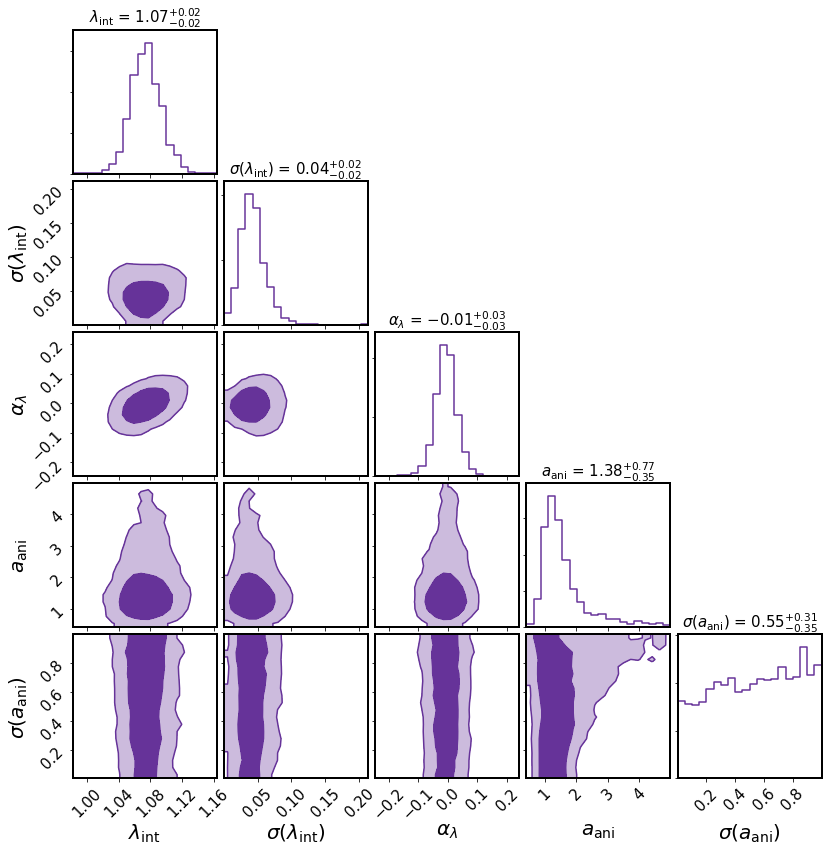

In [14]:
print(np.shape(mcmc_samples_fix_cosmo))

fig = corner.corner(mcmc_samples_fix_cosmo,
                    labels=mcmc_sampler_fix_cosmo.param_names(latex_style=True),
                    bins=20,
                    color='rebeccapurple',
                    hist2d_kwargs={'contourf_kwargs':{'colors': 'Greys'}, 'fill_contours': True},
                    smooth=0.7, smooth1d=0.1,
                    show_titles=True,
                    title_kwargs=dict(fontsize=15),
                    plot_datapoints=False,
                    label_kwargs=dict(fontsize=20),
                    levels=[0.68,0.95],
                    #color=color_map[0],
                    fill_contours=True,
                    #range=extents,
                    #truth_color=truth_color
                   )
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/tdlmc_rung3_fixed_cosmo_'+str(anisotropy_model)+'.pdf')
plt.show()
